## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from vetsuisse25_imaging import *
from vetsuisse25_data_handler import *

08-May-25 14:10:42 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


>>> GPU activated? NO


## Data loading and inspection

Get file paths

In [27]:
data = parse_image_filenames("../imaging_data/21122022_images_jinglecells_SO_AK")
display(data)

,condition,donor,time,date,replicate,mode1,mode2,filename,filepath
0,37mock,BEC5,48h,2022-12-21,None,R3D,D3D,37mock_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...
1,MERS,BEC5,48h,2022-12-21,None,R3D,D3D,MERS_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...


Load one image to inspect

In [28]:
# Load the image
imgs = [AICSImage(data["filepath"][i]) for i in range(len(data))]

# Show basic info
print("Shape:", imgs[0].dims)
print("Dimensions:", imgs[0].shape)  # shape: (T, C, Z, Y, X)

# Example: Get the first timepoint, first channel
img_array = imgs[0].get_image_data("ZYX", T=0, C=0) # 3D image stack
print("Loaded array shape:", img_array.shape) # img_array is now a NumPy array

# Get the first timepoint, all channels for all images
imgs = [imgs[i].get_image_data("CZYX", T=0) for i in range(len(imgs))] # 4D image stack
print("Loaded array shape:", imgs[0].shape) # img_array is now a list of NumPy arrays

Shape: <Dimensions [T: 1, C: 4, Z: 68, Y: 960, X: 960]>
Dimensions: (1, 4, 68, 960, 960)
Loaded array shape: (68, 960, 960)
Loaded array shape: (4, 68, 960, 960)


In [29]:
# v = napari.Viewer()
# v.add_image(imgs[1], name="MERS", colormap="gray", blending="additive")

In [30]:
# print(imgs[0].shape)
# for i in range(4):
#     print(imgs[0][i].min(), imgs[0][i].max(), imgs[0][i].mean(), imgs[0][i].std())

Remove the DAPI channel

In [31]:
imgs = [imgs[i][[1,2,3]] for i in range(len(imgs))]
print(imgs[0].shape, imgs[0].max())

(3, 68, 960, 960) 45075


Show in napari

In [32]:
v = napari.Viewer()
z_stretch = 5
v.add_image(imgs[0], name="Image", colormap="gray", scale=(1, z_stretch, 1, 1))

<Image layer 'Image' at 0x224108f1950>

Create different projections (and normalize them)

In [33]:
mip_imgs, avg_imgs, med_imgs = [], [], []
# mip_norm, avg_norm, med_norm = [], [], []
# Create different projections and normalize them
for i, img in enumerate(imgs):
    mip_img = np.max(img, axis=1).astype(int)    # collapse along Z
    avg_img = np.mean(img, axis=1).astype(int)    # average along Z
    med_img = np.median(img, axis=1).astype(int)    # median along Z

    mip_imgs.append(mip_img.copy())
    avg_imgs.append(avg_img.copy())
    med_imgs.append(med_img.copy())

    # Normalize the images for better visualization
    # mip_img, avg_img, med_img = mip_img.astype(float), avg_img.astype(float), med_img.astype(float)
    # for c in range(3):
    #     mip_img[c] = (mip_img[c] - np.min(mip_img[c])) / (np.max(mip_img[c]) - np.min(mip_img[c]))
    #     avg_img[c] = (avg_img[c] - np.min(avg_img[c])) / (np.max(avg_img[c]) - np.min(avg_img[c]))
    #     med_img[c] = (med_img[c] - np.min(med_img[c])) / (np.max(med_img[c]) - np.min(med_img[c]))

    # mip_norm.append(mip_img.copy())
    # avg_norm.append(avg_img.copy())
    # med_norm.append(med_img.copy())

In [34]:
print(mip_imgs[0].max())
# print(mip_imgs[0].max(), "|", mip_norm[0].max())

45075


Print ranges and plot the images (channels separately)

MIP image range: ['Ch0: 505 - 1966', 'Ch1: 2046 - 44836', 'Ch2: 3561 - 45075']
Average image range: ['Ch0: 394 - 727', 'Ch1: 1689 - 6104', 'Ch2: 2261 - 9732']
Median image range: ['Ch0: 376 - 704', 'Ch1: 1678 - 3973', 'Ch2: 1859 - 7798']


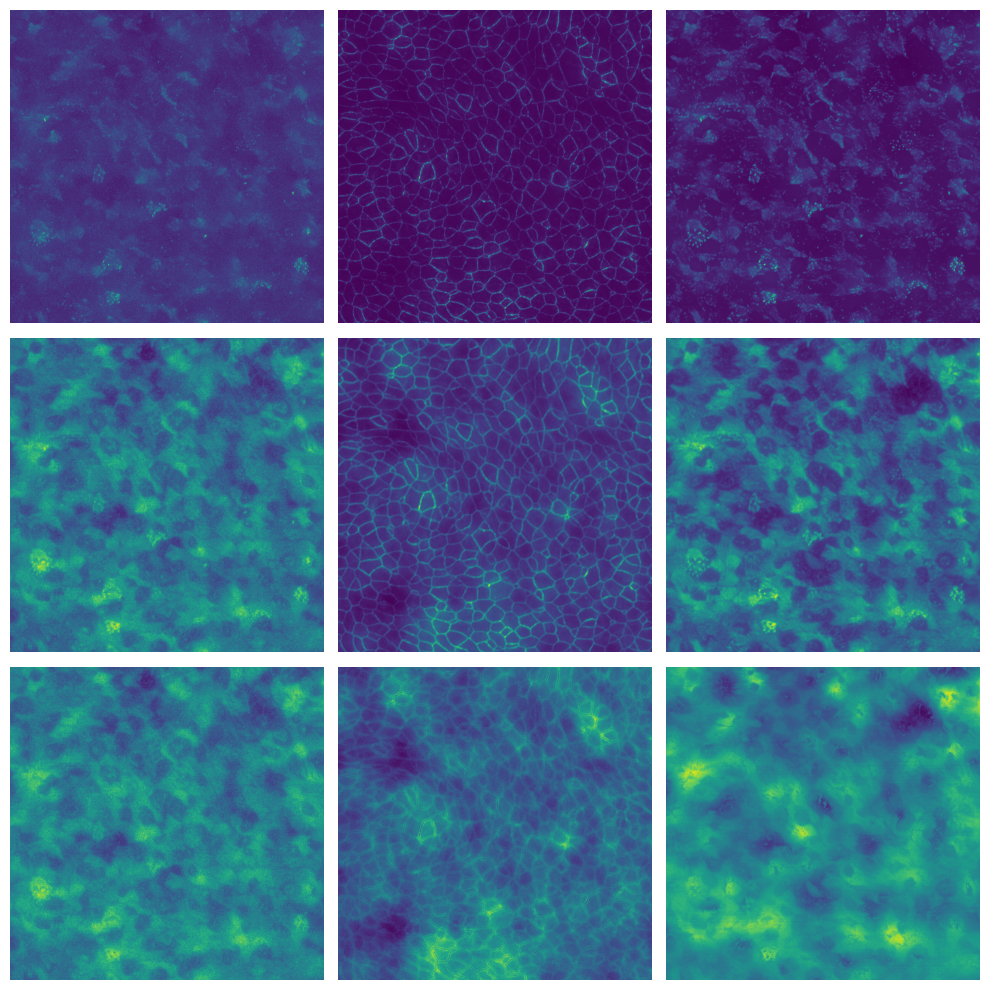

MIP image range: ['Ch0: 643 - 28887', 'Ch1: 3072 - 24992', 'Ch2: 3757 - 22871']
Average image range: ['Ch0: 511 - 8924', 'Ch1: 2571 - 6390', 'Ch2: 2762 - 9147']
Median image range: ['Ch0: 495 - 7749', 'Ch1: 2543 - 5419', 'Ch2: 2442 - 8783']


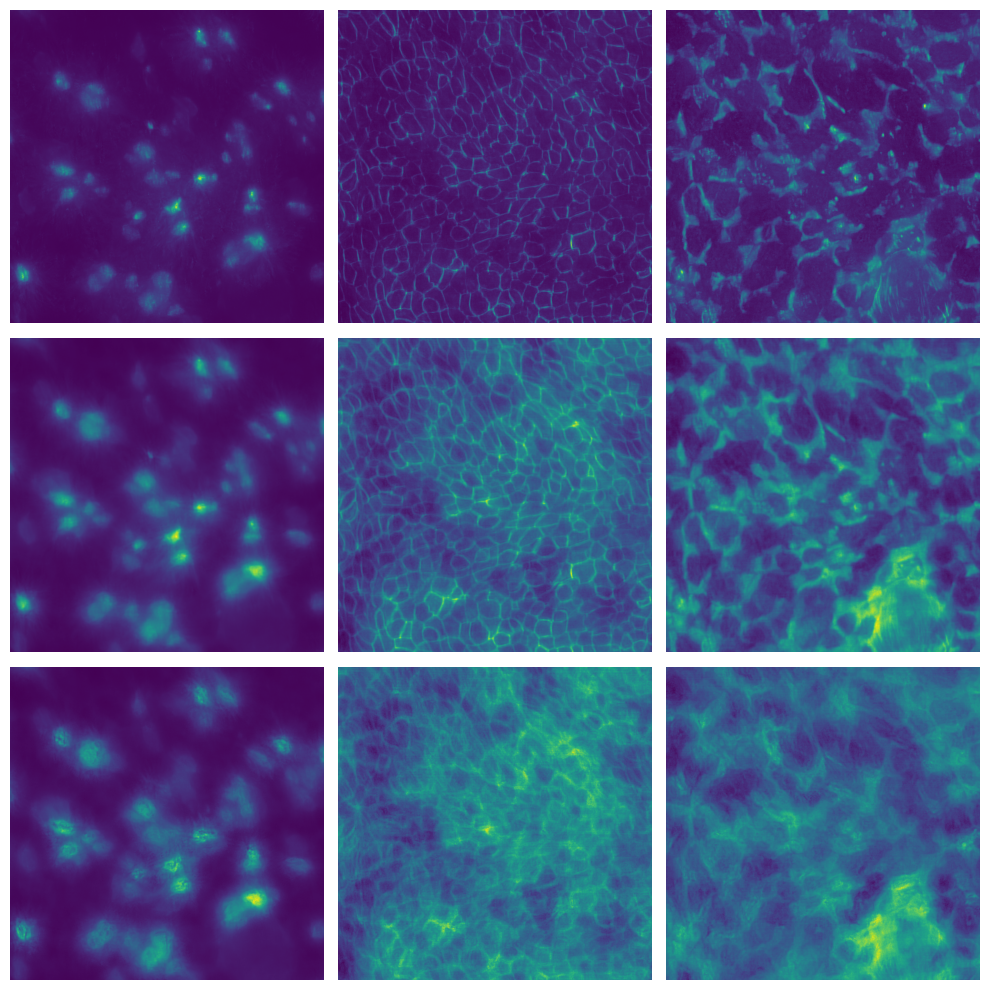

In [36]:
for im_num in range(len(mip_imgs)):
    mip_img, avg_img, med_img = mip_imgs[im_num], avg_imgs[im_num], med_imgs[im_num]

    print("MIP image range:", [f"Ch{i}: {mip_img[i].min()} - {mip_img[i].max()}"for i in range(3)])
    print("Average image range:", [f"Ch{i}: {avg_img[i].min()} - {avg_img[i].max()}"for i in range(3)])
    print("Median image range:", [f"Ch{i}: {med_img[i].min()} - {med_img[i].max()}"for i in range(3)])

    imgs = [mip_img[0], mip_img[1], mip_img[2],
            avg_img[0], avg_img[1], avg_img[2],
            med_img[0], med_img[1], med_img[2]]
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    for i, a in enumerate(ax.flatten()):
        a.axis("off")
        a.imshow(np.moveaxis(imgs[i], 0, -1))
    plt.tight_layout()
    plt.show()

## QUESTIONS

- Which projection for which signal? --> MIP for TJs, try MIP & avg for inf and cilia
- How to normalize the images? Use overall min/max or other statistics (over all samples) for each channel? --> inside batch/experiment, use mock for inf, think about what to use for cilia
- Cilia: are they mostly on the edge or even outside the cell? --> no, mostly on top, and therefore inside projection
- Threshold for infection: use mock as a reference (e.g. thresh = 3 SD above the mean of the mock cells)? --> yes, makes sense
- What do the filenames mean? Which should be averaged, and then which shall be compared (with mean and sd etc.)?
- Need to normalize by area? --> nope... depending on the questions

--> Go through notes on old scripts and see what we want to use as well, and what we can ignore or do better